+++
notebook = true
date = "2018-08-10"
title = "Creep in a rectangle domain with hole under pressure on its top surface"
weight = 151
project = ["ThermoMechanics/CreepBGRa/CreepAfterExcavation/CreepAfterExcavation.prj"]
author = "Wenqing Wang, Noor Hasan"
image = "./figures/mesh.png"
web_subsection = "thermo-mechanics"
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./creep-after-excavation.ipynb" download="creep-after-excavation.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=creep-after-excavation.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/bilke/ogs/-/blob/web-versioning/Tests/Data/ThermoMechanics/CreepBGRa/CreepAfterExcavation/creep-after-excavation.py"><img src="https://img.shields.io/static/v1?label=Source:&message=creep-after-excavation.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/ThermoMechanics/CreepBGRa/CreepAfterExcavation/creep-after-excavation.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

Following up the benchmark about the BGRa creep model described on the
[this page](https://www.opengeosys.org/docs/benchmarks/thermo-mechanics/creepbgra/),
this example represents the creep in the near field of drift
in the deep rock salt after excavation.
The domain and the geometry are shown in the following figure:

![Domain Mesh](./figures/mesh.png "Mesh and Geometry.")

The domain has two material groups, which are highlighted by different
colors.
The material group that is in the top part of the domain represents a
cap rock type, while the other material group is for rock salt.
The material properties of the rocks are given in the following table:
|  | Cap rock | Rock salt | Unit |
| :--- | :--- | :--- | :--- |
| Density | 2000 | 2170 | $\mathrm{kg} / \mathrm{m}^3$ |
| Young's Modulus | 7.0 | 7.65 | GPa |
| Poisson ratio | 0.3 | 2.7 | - |
| Thermal conductivity | 5 | 5 | W/(mK) |

The parameters of the BGRa creep model are
$A = 0.18d^{-1}$, $m = 5$, $Q = 54$ $kJ/mol$ for the rock salt.
For the cap rock, $A$ is set to zero.

The width and the height of the domain are 300 m and 340 m, respectively.
The height of the cap rock portion is 40 m.
The drift to be excavated has a radius of 50 m.

Here we consider the creep of the rock after excavation.
Therefore, we assume a steady state of stress and temperature of
excavation at the beginning of the current simulation.
For this assumption, the boundary conditions are given as:
- top boundary: $\tau_x$ = $\sigma_{xy} = 0$, $\tau_y = \sigma_y = - 10$ $MPa$, $T = 310$ $K$
- two lateral boundaries: normal displacement is fixed, and no heat flux.
- bottom boundary: normal displacement is fixed, and $T = 320 K$
- circle of drift surface: traction free
$(\sigma \cdot \mathbf{n} = 0)$ and $T = 310$ $K$ as excavation conditions.

The boundary conditions of the mechanical process lead to a distinct
stress field after excavation.
Besides, heat capacity is neglected in order to pose a steady state
temperature field after excavation.
The initial stresses are zero and the initial temperature is linearly
distributed from top to bottom with the boundary values of temperature.

The time step sizes of the simulation are: One step of 0.001 day,
10 steps of 0.1 day, and the remaining steps of 1 day.

The following three figures are plotted by using the results of the
simulation of 1000 days creep.
The three figures display the distribution of horizontal and vertical
stresses at times of 109 days, 409 days and 1000 days, respectively.

In these three figures, the left sub-figure show the time variations
of horizontal and vertical stresses at a position just close to the
top of the drift, and the green vertical line in it marks the time
of the displayed stress field.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot

In [2]:
# creating output path if it doesn't exist already.
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
model = ot.Project(
    input_file="CreepAfterExcavation.prj",
    output_file="CreepAfterExcavation_modified.prj",
)
# Update end time of simulation
model.replace_text(
    xpath="./time_loop/processes/process/time_stepping/t_end", value="86400.0e+3"
)
model.write_input()

In [4]:
model.run_model(logfile=Path(out_dir) / "log.txt")

Project file written to output.
Simulation: CreepAfterExcavation_modified.prj
Status: finished successfully.
Execution took 167.1352424621582 s


In [5]:
ms = ot.MeshSeries("CreepAfterExcavation.pvd").scale(time=("s", "d"))

ts_109d = np.where(np.round(ms.timevalues) == 109)[0].item()  # 109 days
ts_409d = np.where(np.round(ms.timevalues) == 409)[0].item()  # 409 days
ts_1000d = np.where(np.round(ms.timevalues) == 1000)[0].item()  # 1000 days

ms_109d = ms.mesh(ts_109d)
ms_409d = ms.mesh(ts_409d)
ms_1000d = ms.mesh(ts_1000d)

In [6]:
def plot_stress_dist(day, mesh):
    obs_pts = np.array([150.0, -600, 0])
    ms_pts = ot.MeshSeries.extract_probe(ms, obs_pts)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))
    ot.plot.line(
        ms_pts,
        "time",
        ot.variables.stress["xx"],
        ax=ax[0],
        fontsize=15,
        label="stress xx",
    )
    ot.plot.line(
        ms_pts,
        "time",
        ot.variables.stress["yy"],
        ax=ax[0],
        fontsize=15,
        color="red",
        label="stress yy",
    )
    ax[0].axvline(day, color="green")

    mesh.plot_contourf(ot.variables.stress["xx"], fig=fig, ax=ax[1], fontsize=15)
    mesh.plot_contourf(ot.variables.stress["yy"], fig=fig, ax=ax[2], fontsize=15)

    fig.suptitle(f"Stress distribution at the time of {day} days", fontsize=20)
    plt.tight_layout()
    plt.show()

Now the stress distributions at 109, 409, and 1000 days will be plotted:

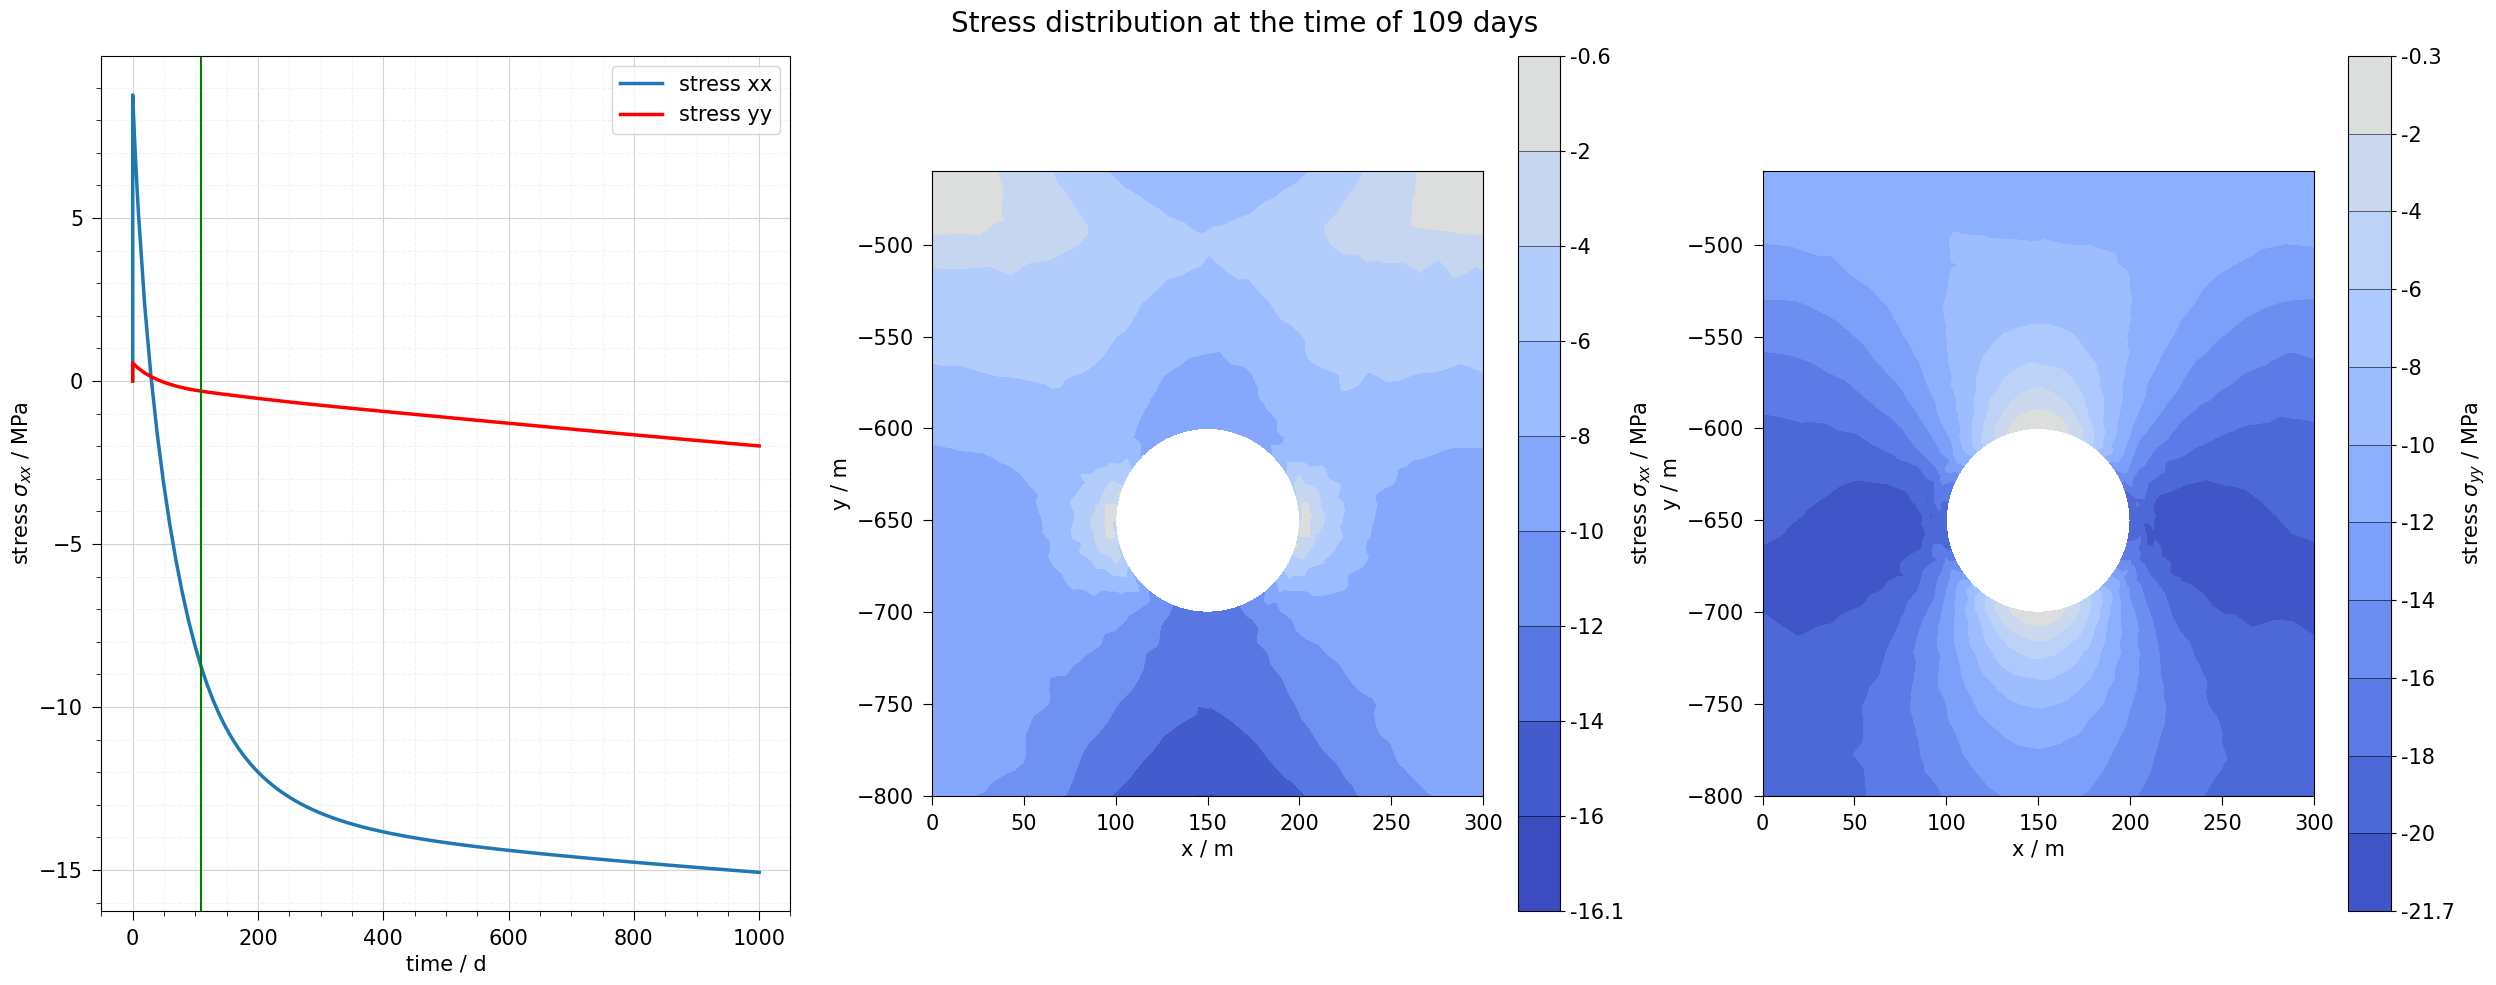

In [7]:
# Stress distrubtion at 109 days
plot_stress_dist(109, ms_109d)

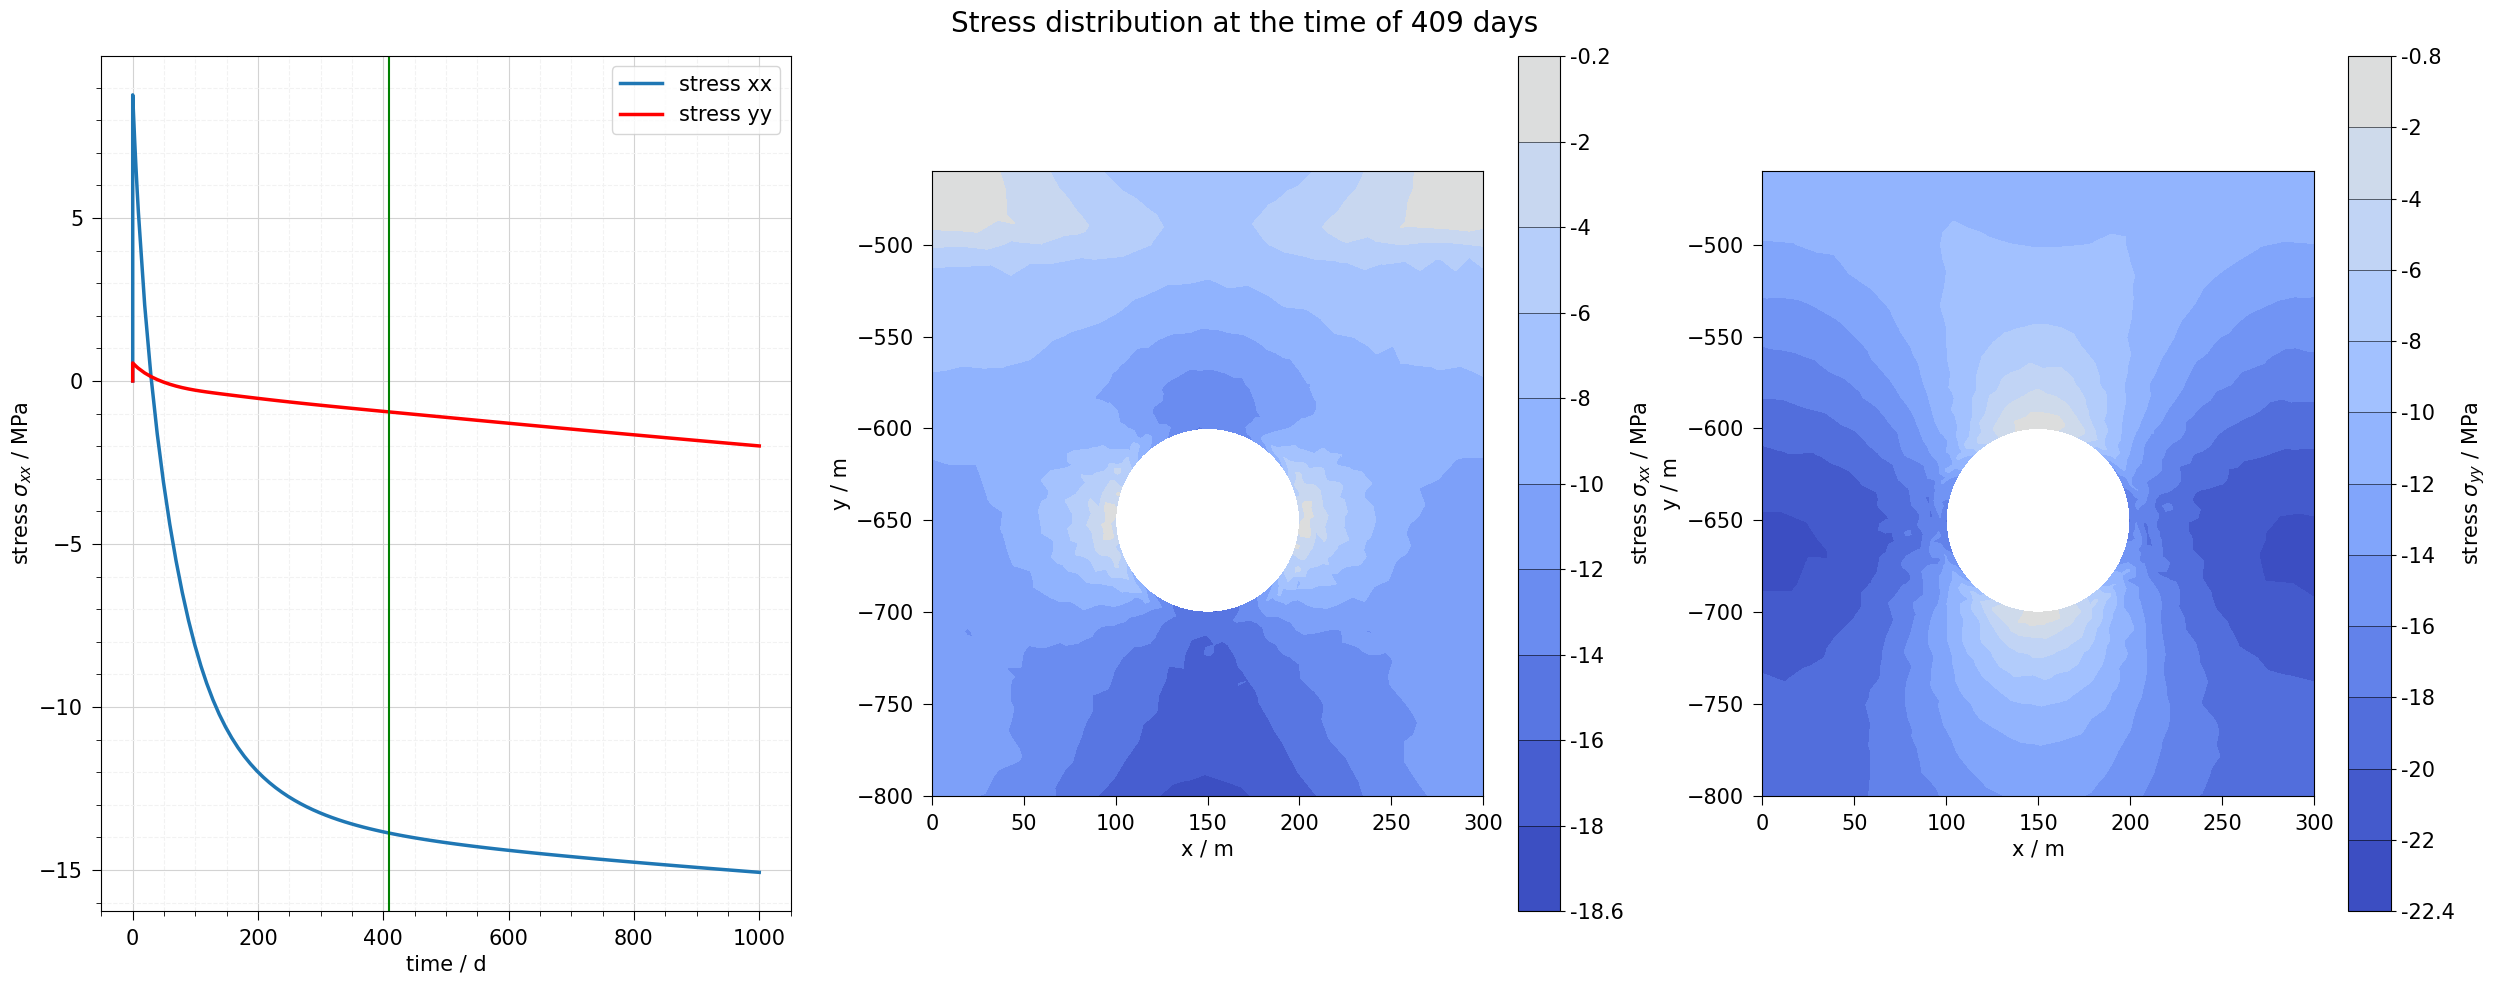

In [8]:
# Stress distrubtion at 409 days
plot_stress_dist(409, ms_409d)

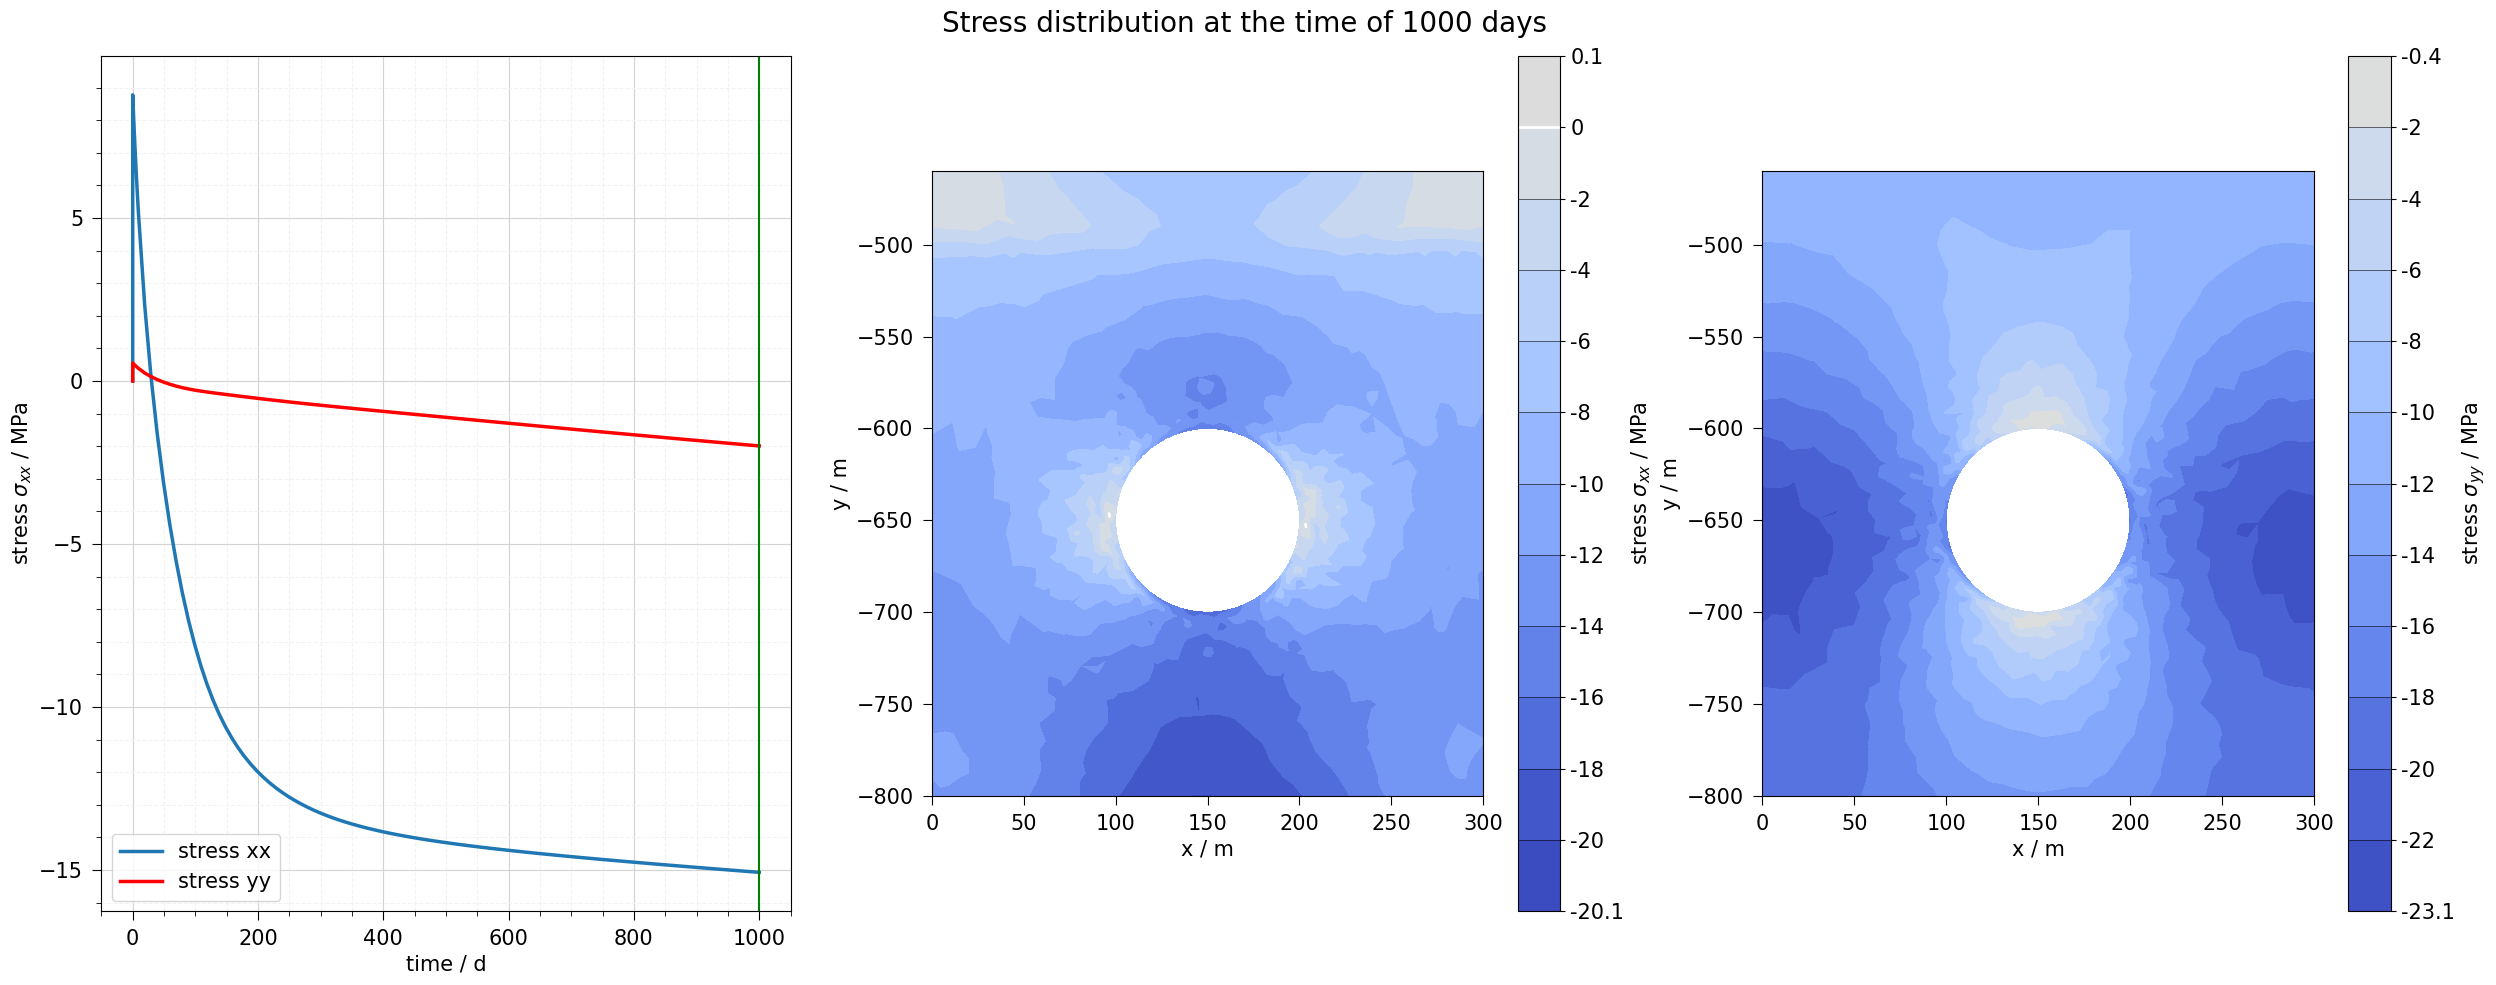

In [9]:
# Stress distrubtion at 1000 days
plot_stress_dist(1000, ms_1000d)

The above three figures show that the absolute value of the horizontal
stress increase signification in the areas above and beneath the drift
due to the creep, and the change of the vertical stress is slow compared
to that of the horizontal stress.

The following figure shows the strain distribution at the end of the
simulation time at 1000 days.

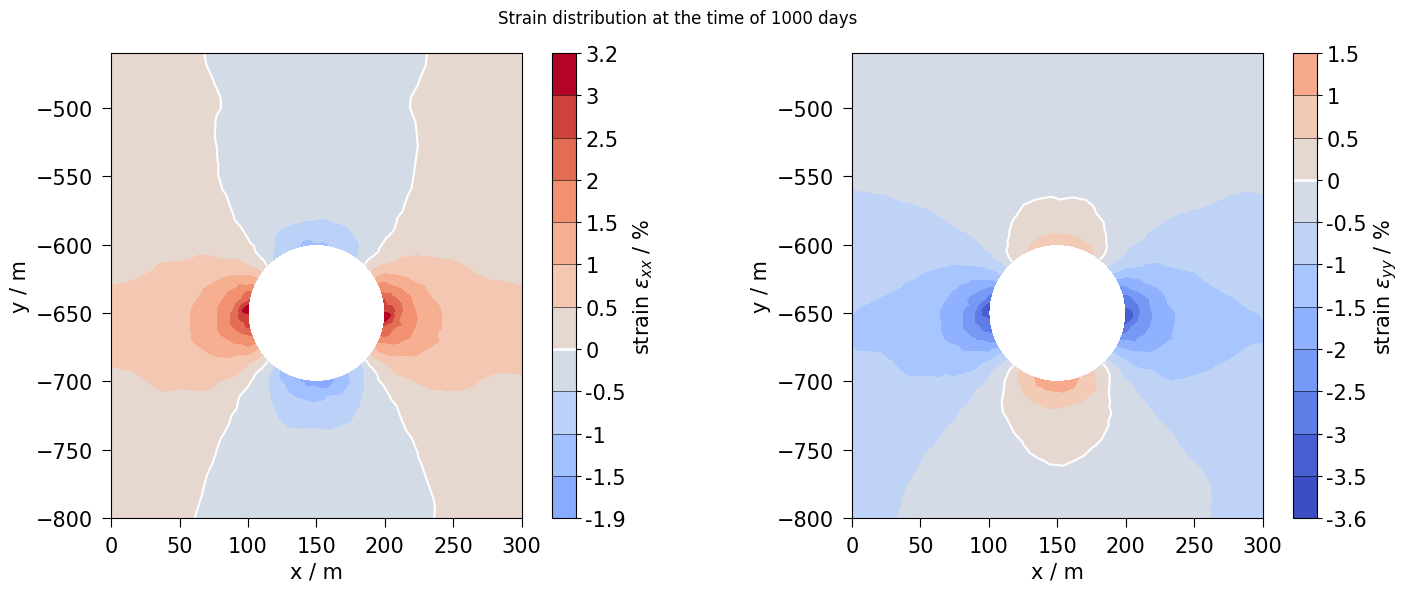

In [10]:
fig_strain, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ms_1000d.plot_contourf(ot.variables.strain["xx"], fig=fig_strain, ax=ax[0], fontsize=15)
ms_1000d.plot_contourf(ot.variables.strain["yy"], fig=fig_strain, ax=ax[1], fontsize=15)

fig_strain.suptitle("Strain distribution at the time of 1000 days")
plt.tight_layout()
plt.show()

The steady-state temperature distribution is displayed in the following figure

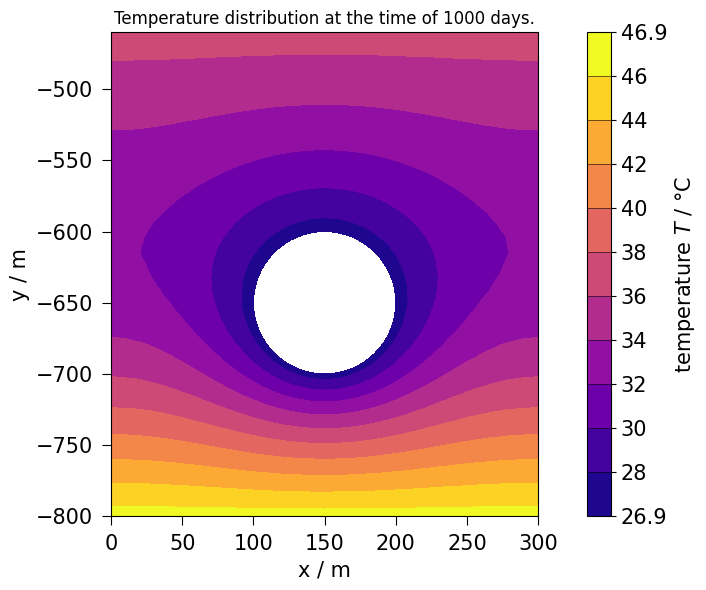

In [11]:
fig_temp, ax = plt.subplots(figsize=(10, 6))

ms_1000d.plot_contourf(ot.variables.temperature, fig=fig_temp, ax=ax, fontsize=15)
ax.set_title("Temperature distribution at the time of 1000 days.")

plt.tight_layout()
plt.show()